# Quantum Kernel Machine Learning

## Overview

Machine learning aims to identify and analyze patterns within data. For many datasets, representing data points in a higher-dimensional feature space can reveal more meaningful relationships. This concept forms the basis of kernel methods in machine learning.

In this notebook, you'll explore how to define quantum kernels using `qiskit-machine-learning` and integrate them into various algorithms for classification and clustering tasks.

The examples in this tutorial are inspired by the reference paper: *Supervised learning with quantum enhanced feature spaces*.

# 1. Introduction

## 1.1. Kernel Methods for Machine Learning

In this project, I explore kernel methods—powerful pattern analysis algorithms that use kernel functions to operate in high-dimensional feature spaces. My main focus is on Support Vector Machines (SVMs), which are widely used for classification tasks. SVMs aim to find decision boundaries that separate data points into different classes. When data isn't linearly separable, kernels help by mapping the data into a higher-dimensional space, making it easier to find these boundaries. This approach is known as the “kernel trick.”

Kernel methods aren't limited to supervised learning; they also play a role in unsupervised algorithms like clustering. For example, Spectral Clustering treats data points as nodes in a graph and partitions them into clusters by mapping them into a space where clusters are more easily identified.

## 1.2. Kernel Functions

Mathematically, kernel functions are defined as follows:

$$
k(x, x') = \langle \phi(x), \phi(x') \rangle
$$

where  
- $k$ is the kernel function  
- $x, x'$ are input vectors  
- $\phi$ is a mapping from the input space to a higher-dimensional feature space  
- $\langle \cdot, \cdot \rangle$ denotes the inner product

For finite datasets, the kernel function can be represented as a matrix:

$$
K_{ij} = k(x_i, x_j)
$$

## 1.3. Quantum Kernels

The core idea of quantum kernel machine learning is to use quantum feature maps for the kernel trick. Here, a quantum kernel is constructed by mapping a classical feature vector $x$ to a Hilbert space using a quantum feature map $\phi$. The quantum kernel is then:

$$
K_{ij} = |\langle \phi(x_i) | \phi(x_j) \rangle|^2
$$

where  
- $K$ is the kernel matrix  
- $x_i, x_j$ are input vectors  
- $\phi$ is the quantum feature map  
- $\langle \phi(x_i) | \phi(x_j) \rangle$ is the overlap between two quantum states

Quantum kernels can be integrated into classical kernel learning algorithms like SVMs and clustering methods. In this project, I experiment with quantum kernels using the `qiskit-machine-learning` library, including the QSVC class and other advanced quantum kernel techniques.

In [1]:
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 12345

## 2. Classification

In this section, I demonstrate a quantum kernel classification workflow using `qiskit-machine-learning`.

### 2.1. Defining the Dataset

For my experiments, I use the ad hoc dataset introduced in the reference paper.

I specify the dataset dimension and prepare the training and test subsets for the classification task.

In [2]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

This dataset is two-dimensional, the two features are represented by the x and y coordinates, and it has two labels: A and B. We can plot it and see what the distribution looks like.

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

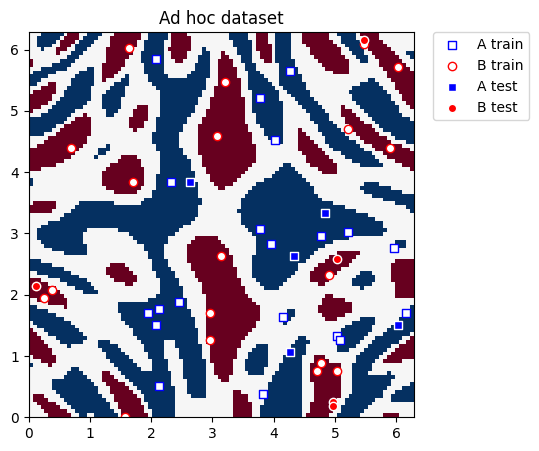

In [4]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

## 2.2. Defining the Quantum Kernel

Now I define the quantum kernel that will be used for classification.

For this project, I use the `FidelityQuantumKernel` class from Qiskit. I initialize it with two main components:

- **feature_map**: I choose a two-qubit `ZZFeatureMap` to encode the data.
- **fidelity**: I use the `ComputeUncompute` fidelity subroutine, which utilizes the `Sampler` primitive.

*Note: If I don’t explicitly provide a `Sampler` or `Fidelity` instance, Qiskit will automatically create default instances of `Sampler` and `ComputeUncompute` from `qiskit.primitives`.*

In [5]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel


adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

### 2.3. Classification with SVC

In my project, I integrate the quantum kernel into classical kernel methods, specifically using the SVC algorithm from scikit-learn. This approach lets me leverage quantum-enhanced feature spaces within a familiar classical machine learning framework.

There are two main ways to use a custom kernel with SVC:

- **Providing the kernel as a callable function:**  
    I can pass the quantum kernel’s `evaluate` method directly to SVC, allowing it to compute kernel values on the fly.

- **Precomputing the kernel matrix:**  
    Alternatively, I can compute the kernel matrix in advance and supply it to SVC.

#### Kernel as a Callable Function

For this workflow, I define an SVC model and pass the quantum kernel’s `evaluate` function as the kernel. I then train the model using the `fit` method on my training data and assess its accuracy with the `score` method. This setup enables me to explore the performance of quantum kernels in a standard classification pipeline.

In [6]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(train_features, train_labels)

adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score_callable_function:.2f}")

Callable kernel classification test score: 1.00


### Precomputed Kernel Matrix

Instead of passing the quantum kernel as a callable function, I can also precompute the training and testing kernel matrices before using them with the scikit-learn SVC algorithm.

To do this, I call `evaluate` on my previously defined quantum kernel to extract the train and test matrices. I then visualize these matrices to better understand the structure of the quantum feature space.

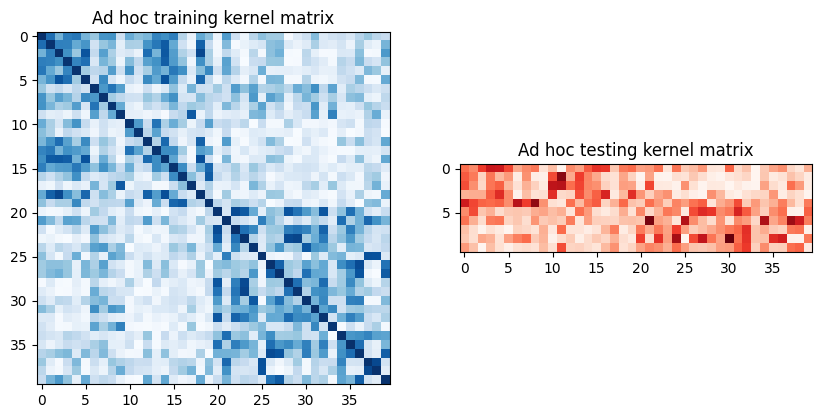

In [7]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

To use these matrices, we set the kernel parameter of a new SVC instance to "precomputed". We train the classifier by ccalling fit with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset.

In [8]:
adhoc_svc= SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)
print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel:.2f}")

Precomputed kernel classification test score: 1.00


### 2.4. Classification with QSVC

For my project, I also experiment with the `QSVC` class from `qiskit-machine-learning`. `QSVC` is a convenient extension of scikit-learn’s `SVC` that directly accepts a quantum kernel object, making it easy to integrate quantum kernels into the classification workflow. This approach streamlines the process compared to passing the `evaluate` method manually, and allows me to explore quantum-enhanced classification using a familiar API.

In [9]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score:.2f}")

QSVC classification test score: 1.00


2.5 Evaluation of models used for classification

In [10]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00


## 3. Clustering

For the second part of my project, I focus on a clustering task using `qiskit-machine-learning` together with the spectral clustering algorithm from scikit-learn.

### 3.1. Defining the Dataset

I use the same ad hoc dataset as before, but this time I generate it with a larger gap of 0.6 between the two classes (compared to 0.3 in the classification example). Since clustering is an unsupervised learning task, I only need a single dataset and do not require a separate test set.

In [16]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=True,
    include_sample_total=True,
)

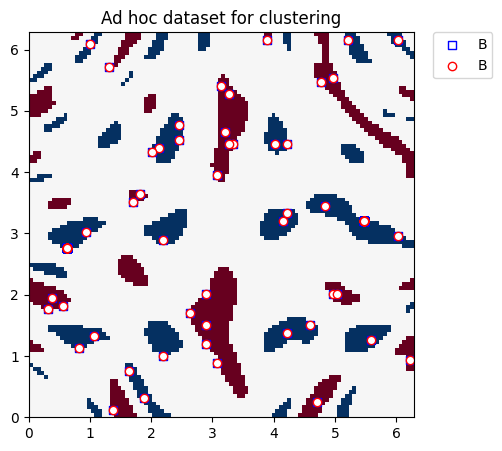

In [17]:
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

# A label plot
plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "B")

# B label plot
plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for clustering")

plt.show()

### 3.2. Defining the Quantum Kernel

For my clustering experiments, I use the same approach as in the classification section. I construct a new instance of `FidelityQuantumKernel` with a `ZZFeatureMap` to encode the data, ensuring consistency across both tasks in my project.

In [18]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)


### 3.3. Clustering with Spectral Clustering

In my project, I use the spectral clustering algorithm from scikit-learn to perform unsupervised learning with quantum kernels. Similar to SVC, spectral clustering supports custom kernels in two ways: by passing a callable kernel function or by supplying a precomputed kernel matrix.

However, with the current implementation of `FidelityQuantumKernel` in `qiskit-machine-learning`, only the precomputed kernel matrix approach is supported. Therefore, I precompute the kernel matrix using the `evaluate` method and visualize it to better understand the quantum feature space.

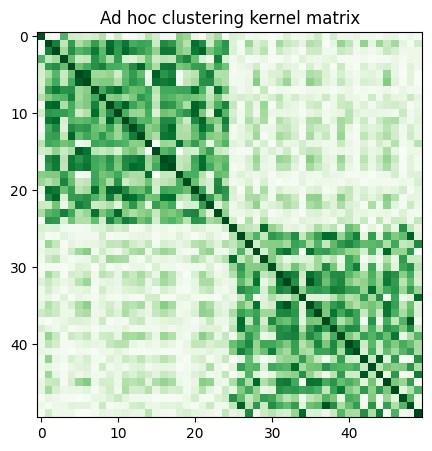

In [19]:
adhoc_matrix = adhoc_kernel.evaluate(x_vec=train_features)

plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(adhoc_matrix), interpolation="nearest", origin="upper", cmap="Greens")
plt.title("Ad hoc clustering kernel matrix")
plt.show()

We define a spectral clustering model and fit it using the precomputed kernel. Further, we score the labels using the normalized mutual information, since we know the class labels a priori(before hand)

In [20]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

adhoc_spectral = SpectralClustering(2, affinity="precomputed")

cluster_labels = adhoc_spectral.fit_predict(adhoc_matrix)

cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

print(f"Clustering score: {cluster_score}")

ValueError: labels_pred must be 1D: shape is (50, 2)